# Requirements

In [139]:
import pandas as pd
from keras.layers import LSTM, Dense, Dropout
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the future **count of page loads**. To accomplish this use data from the past three days, which includes information such as the **count of page loads**, **count of unique visits**, **count of first time-visits**, and **count of returning visits**. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast the future **count of page loads** based on the provided historical data.

## The Website Visitors Dataset

## Downloading the Website Visitors Dataset

In [140]:
!gdown 1h1P3NboXKbWNngqgCB1i4bHFRcv7uDJe

Downloading...
From: https://drive.google.com/uc?id=1h1P3NboXKbWNngqgCB1i4bHFRcv7uDJe
To: /content/website-visitors.csv
100% 92.8k/92.8k [00:00<00:00, 62.2MB/s]


In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploring the Website Visitors Dataset
This datatset consists of daily counts of page loads, unique visitors, first-time visitors, and returning visitors for an academic teaching notes website. The dataset contains 2167 rows spanning from September 14, 2014, to August 19, 2020. A visit is defined as a series of hits on one or more pages by the same user on a given day, identified by IP address. Shared IP addresses are considered a single user. A visit is "unique" if a hit from the same IP address hasn't occurred within the last 6 hours. Returning visitors are identified by cookies, and the rest are classified as first-time visitors. The unique visitor count is the sum of returning and first-time visitors.

The dataset consists of the following columns:
- date - date in mm/dd/yyyy format,
- day_of_week - day of the week in text form (Monday, Tuesday, etc.),
- page_loads - daily number of pages loaded,
- unique_visits - daily number of visitors from IP addresses with no hits in over 6 hours,
- first_time_visits - number of unique visitors without a identifying cookie, and
- returning_visits - number of unique visitors minus first-time visitors.

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

array([[<Axes: title={'center': 'page_loads'}>,
        <Axes: title={'center': 'unique_visits'}>],
       [<Axes: title={'center': 'first_time_visits'}>,
        <Axes: title={'center': 'returning_visits'}>]], dtype=object)

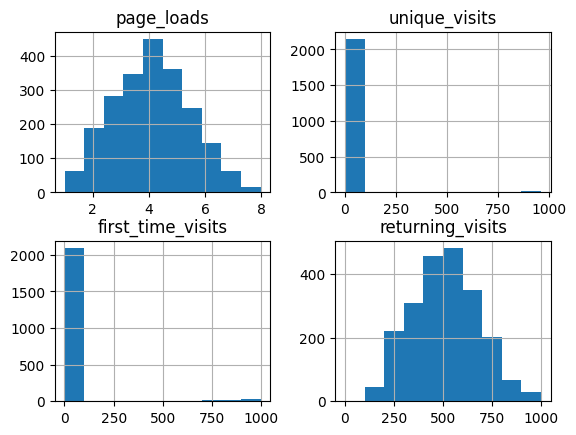

In [142]:
# Write your code here. Add as many boxes as you need.
data = pd.read_csv('website-visitors.csv')
data.head()
data.hist()

Explore the dataset using visualizations of your choice.

In [143]:
# Write your code here. Add as many boxes as you need.

Drop the column **day_of_week**, because we won't use it.

In [144]:
data=data.drop(columns=['day_of_week'])
data.head()

,date,page_loads,unique_visits,first_time_visits,returning_visits
0,9/14/2014,2.146,1.582,1.430,152.0
1,9/15/2014,3.621,2.528,2.297,231.0
2,9/16/2014,3.698,2.630,2.352,278.0
3,9/17/2014,3.667,2.614,2.327,287.0
4,9/18/2014,3.316,2.366,2.130,236.0


## Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

*Be careful when extracting the features. For each day, ensure that features are obtained sequentially, starting with those from 3 days ago, followed by features from 2 days ago, and finally, features from 1 day ago. This becomes crucial when reshaping the train and test sets later on.*

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [145]:
# Write your code here. Add as many boxes as you need.data = data.sort_values(by='date', ascending=False)
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')
tmp=['page_loads', 'unique_visits', 'first_time_visits', 'returning_visits']
for i in range(3,0,-1):
  for t in tmp:
    data[f'{t} from {i} days ago'] = data[f'{t}'].shift(i)

tmp=['unique_visits', 'first_time_visits', 'returning_visits']
data.drop(columns=tmp, inplace=True)

data.head(10)

,date,page_loads,page_loads from 3 days ago,unique_visits from 3 days ago,first_time_visits from 3 days ago,returning_visits from 3 days ago,page_loads from 2 days ago,unique_visits from 2 days ago,first_time_visits from 2 days ago,returning_visits from 2 days ago,page_loads from 1 days ago,unique_visits from 1 days ago,first_time_visits from 1 days ago,returning_visits from 1 days ago
0,2014-09-14,2.146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-15,3.621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.146,1.582,1.430,152.0
2,2014-09-16,3.698,NaN,NaN,NaN,NaN,2.146,1.582,1.430,152.0,3.621,2.528,2.297,231.0
3,2014-09-17,3.667,2.146,1.582,1.430,152.0,3.621,2.528,2.297,231.0,3.698,2.630,2.352,278.0
4,2014-09-18,3.316,3.621,2.528,2.297,231.0,3.698,2.630,2.352,278.0,3.667,2.614,2.327,287.0
5,2014-09-19,2.815,3.698,2.630,2.352,278.0,3.667,2.614,2.327,287.0,3.316,2.366,2.130,236.0
6,2014-09-20,1.658,3.667,2.614,2.327,287.0,3.316,2.366,2.130,236.0,2.815,1.863,1.622,241.0
7,2014-09-21,2.288,3.316,2.366,2.130,236.0,2.815,1.863,1.622,241.0,1.658,1.118,985.000,133.0
8,2014-09-22,3.638,2.815,1.863,1.622,241.0,1.658,1.118,985.000,133.0,2.288,1.656,1.481,175.0
9,2014-09-23,4.462,1.658,1.118,985.000,133.0,2.288,1.656,1.481,175.0,3.638,2.586,2.312,274.0


In [146]:
data.tail(5)
data.dropna(subset=data.columns,axis=0,inplace=True)


In [147]:
data.drop('date',axis=1,inplace=True)

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [148]:
# Write your code here. Add as many boxes as you need.
X, Y = data.drop('page_loads',axis=1), data['page_loads']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Feauture Scaling
Scale the extracted features using an appropriate scaler.

In [149]:
#Write your code here. Add as many boxes as you need.
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [150]:
# Write your code here. Add as many boxes as you need.
X_train = X_train.reshape(X_train.shape[0], 3, 4)


In [151]:
X_train

array([[[-1.43123427, -0.13570258, -0.21395264, -2.12313503],
        [-0.3709459 , -0.12704174, -0.20883874, -1.6760511 ],
        [-0.31583557, -0.12610981, -0.2085147 , -1.40987038]],

       [[-0.36964962, -0.12703272, -0.20883434, -1.67248588],
        [-0.31549833, -0.12610693, -0.20851405, -1.40760565],
        [-0.33815926, -0.12625645, -0.20866228, -1.35842592]],

       [[-0.3142313 , -0.12609792, -0.20850965, -1.40437815],
        [-0.33782137, -0.12625357, -0.20866163, -1.3562012 ],
        [-0.59092099, -0.12852931, -0.20982526, -1.64994456]],

       ...,

       [[-1.41396103, -0.13569341, -0.2145784 , -1.51276213],
        [-0.95494563, -0.13252227, -0.21303609, -1.03063969],
        [ 0.20409026, -0.12244391, -0.20785941,  0.24206856]],

       [[-0.95334125, -0.13251324, -0.2130317 , -1.02788645],
        [ 0.20441266, -0.12244103, -0.20785876,  0.24304833],
        [ 0.47269461, -0.12035434, -0.20667282,  0.39640196]],

       [[ 0.20540539, -0.12243201, -0.20785437,

## Long Short-Term Memory (LSTM) Network
Build a Long Short-Term Memory (LSTM) Network for forecasting the future **count of page loads** based on the extracted features from the previous three days.

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [152]:
# Write your code here. Add as many boxes as you need.
model = Sequential()
model.add(LSTM(32,  activation='relu',  return_sequences=True))
model.add(LSTM(8,  activation='relu'))
model.add(Dense(1, activation='linear'))

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [153]:
# Write your code here. Add as many boxes as you need.
model.compile(loss=keras.losses.MeanSquaredError() , optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError() ])

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [154]:
# Write your code here. Add as many boxes as you need.
history = model.fit(X_train, Y_train, batch_size=16, validation_split=0.2, epochs=50, shuffle=False)

Epoch 1/50
87/87 [==============================] - 4s 11ms/step - loss: 0.9244 - mean_squared_error: 0.9244 - mean_absolute_error: 0.7875 - val_loss: 1.0060 - val_mean_squared_error: 1.0060 - val_mean_absolute_error: 0.8135
Epoch 2/50
87/87 [==============================] - 1s 6ms/step - loss: 0.7685 - mean_squared_error: 0.7685 - mean_absolute_error: 0.7207 - val_loss: 0.7745 - val_mean_squared_error: 0.7745 - val_mean_absolute_error: 0.7237
Epoch 3/50
87/87 [==============================] - 1s 6ms/step - loss: 0.5789 - mean_squared_error: 0.5789 - mean_absolute_error: 0.6159 - val_loss: 0.5874 - val_mean_squared_error: 0.5874 - val_mean_absolute_error: 0.6124
Epoch 4/50
87/87 [==============================] - 1s 6ms/step - loss: 0.4759 - mean_squared_error: 0.4759 - mean_absolute_error: 0.5450 - val_loss: 0.5146 - val_mean_squared_error: 0.5146 - val_mean_absolute_error: 0.5654
Epoch 5/50
87/87 [==============================] - 1s 6ms/step - loss: 0.4116 - mean_squared_error: 0.

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

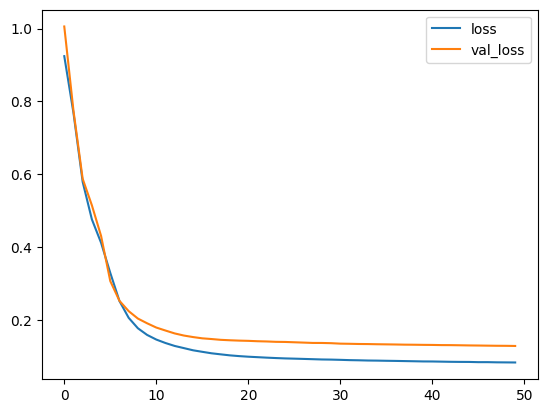

In [155]:
# Write your code here. Add as many boxes as you need.
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

Use the trained model to make predictions for the test set.

In [156]:
X_test = X_test.reshape(X_test.shape[0], 3, 4)


In [157]:
# Write your code here. Add as many boxes as you need.
preds = model.predict(X_test)

14/14 [==============================] - 0s 2ms/step


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [158]:
# Write your code here. Add as many boxes as you need.
preds = scaler.inverse_transform(preds)

In [159]:
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(0.24252649727855552, 0.36338553537452467, 0.801370369462111)

Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

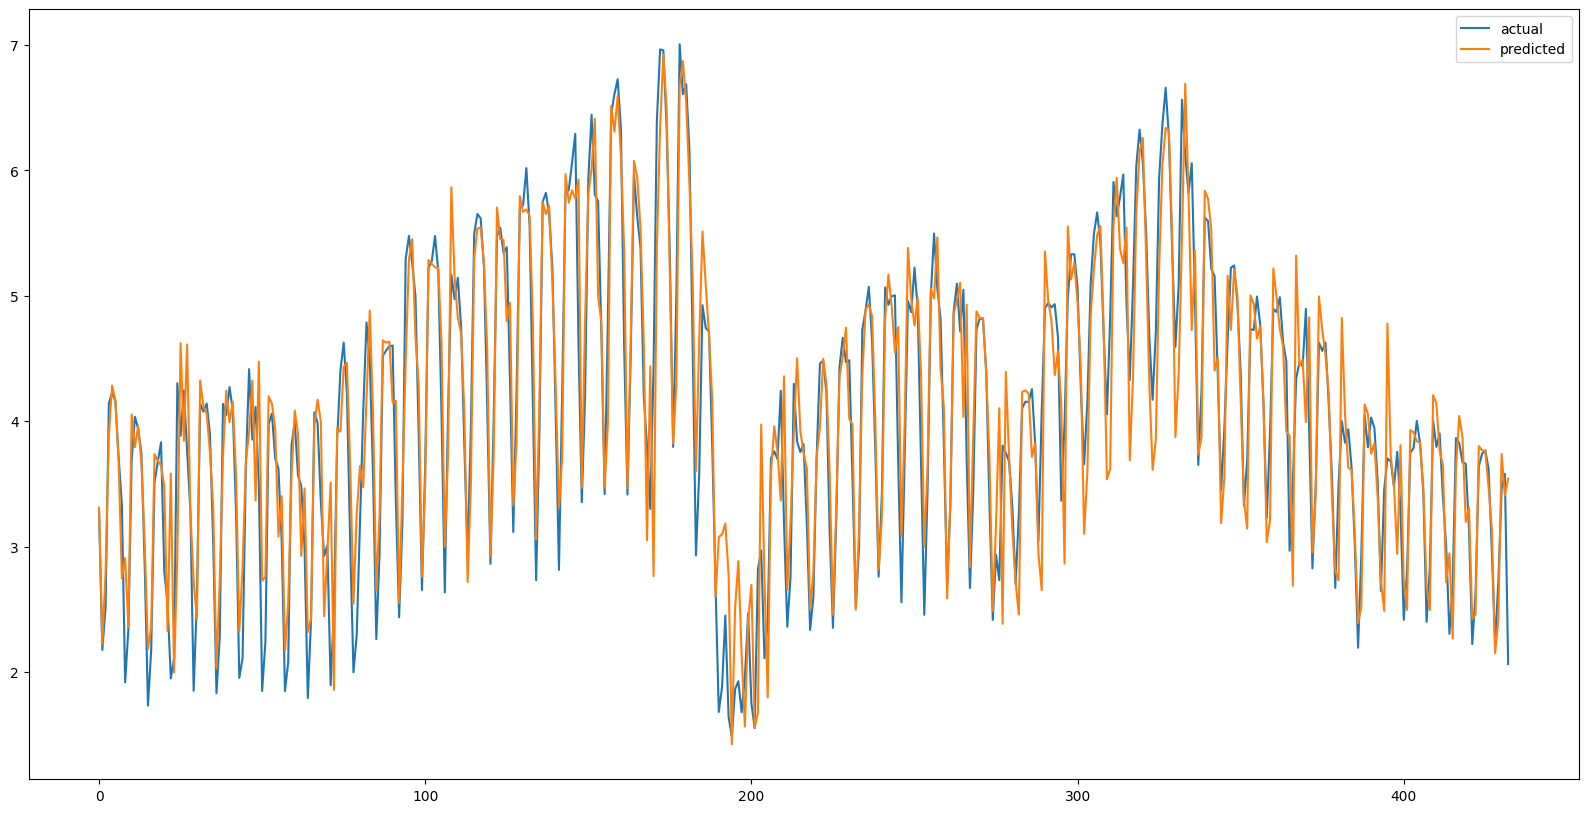

In [160]:
# Write your code here. Add as many boxes as you need.
plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()

# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to perform a sentiment analysis on a dataset consisting of wine reviews. The dataset contains two attributes: **description** and **points**. The description is a brief text describing the wine and the points which represents a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is exceptional based on its review.

The greater part of the code for the solution is already given. You need to define a tokenizer to tokenize the given texts and a deep neural network model that will be used for the classification task at hand. Fill in only the missing code blocks.

## Requirements

## Downloading the Wine Reviews Dataset

In [161]:
!gdown 1fz9449M9Owofy6CYrKzkGwXKesI32B8u

Downloading...
From: https://drive.google.com/uc?id=1fz9449M9Owofy6CYrKzkGwXKesI32B8u
To: /content/wine-reviews.csv
100% 32.5M/32.5M [00:00<00:00, 172MB/s]


## Exploring the Climate Dataset

Load the dataset into a `pandas` data frame.

In [162]:
df = pd.read_csv('/content/wine-reviews.csv')
df

,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87
...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,90
129967,Citation is given as much as a decade of bottl...,90
129968,Well-drained gravel soil gives this wine its c...,90
129969,"A dry style of Pinot Gris, this is crisp with ...",90


## Feature Extraction

Extract the feature `exceptional` for each wine review.

In [163]:
def label_exceptional(points):
    if points >= 90:
        return 1
    else:
        return 0

df['exceptional'] = df['points'].apply(label_exceptional)

In [164]:
# exceptional_df = df[df['points'] >= 90]

In [165]:
# exceptional_df

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

In [166]:
X = df['description']
y = df['exceptional']

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Text Tokenization

Use tokenizer to convert raw text into a sequence of tokens.

In [168]:
tokenizer = Tokenizer()

In [169]:
tokenizer.fit_on_texts(X_train)

In [170]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

## Padding
Pad each sequence to maximum length of 16.

In [171]:
max_length = 16
X_train_padded = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

## Deep Neural Network

Define Deep Neural Network model to predict if a specific wine is exceptional or not based on the tokenized and padded wine reviews.

In [172]:
vocab_size = len(tokenizer.word_index) + 1

In [173]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

Compile the previously defined model specifying loss function, optimizer and evaluation metrics.

In [174]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Fit the compiled model on the train set specifying the percent for validation, batch_size, and number of epochs.

In [176]:
batch_size = 64
epochs = 4

history = model.fit(X_train_padded, y_train,
                    validation_split=0.2,
                    batch_size=batch_size,
                    epochs=epochs)

Epoch 1/4
1300/1300 [==============================] - 78s 60ms/step - loss: 0.4652 - accuracy: 0.7741 - val_loss: 0.4519 - val_accuracy: 0.7830
Epoch 2/4
1300/1300 [==============================] - 79s 60ms/step - loss: 0.3598 - accuracy: 0.8343 - val_loss: 0.4767 - val_accuracy: 0.7802
Epoch 3/4
1300/1300 [==============================] - 72s 55ms/step - loss: 0.2557 - accuracy: 0.8854 - val_loss: 0.5762 - val_accuracy: 0.7736
Epoch 4/4
1300/1300 [==============================] - 72s 55ms/step - loss: 0.1826 - accuracy: 0.9200 - val_loss: 0.7239 - val_accuracy: 0.7671


Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

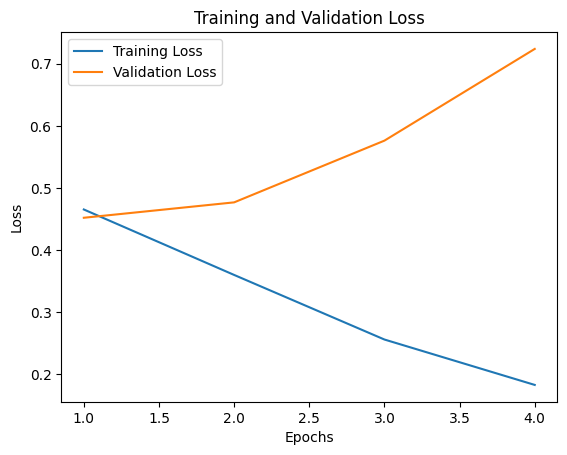

In [177]:
# Get training and validation loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Use the trained model to make predictions for the test set.

In [178]:
predictions = model.predict(X_test_padded)

813/813 [==============================] - 2s 2ms/step


In [179]:
binary_predictions = (predictions > 0.5).astype(int)

In [180]:
binary_predictions[:10]

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0]])

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [181]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [183]:
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy:", accuracy)

precision = precision_score(y_test, binary_predictions)
print("Precision:", precision)

recall = recall_score(y_test, binary_predictions)
print("Recall:", recall)

f1 = f1_score(y_test, binary_predictions)
print("F1-score:", f1)

Accuracy: 0.7724562415849202
Precision: 0.7075885689821256
Recall: 0.6750051051664284
F1-score: 0.6909128912577729
